# Detector Response Tests

Demonstrate the conversion of neutrino flux at Earth to observed hits in IceCube.

Hit estimates from ASTERIA are compared to equivalent output from the USSR C++ code.

In [1]:
%matplotlib inline

from asteria import config, source, interactions
from asteria.neutrino import Flavor
from asteria.detector import Detector

import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=20)

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [2]:
conf = config.load_config('../../data/config/test.yaml')
ccsn = source.initialize(conf)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) at which to perform the simulation. 

In [3]:
# Define neutrino energy spectrum
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

## Compute Charged Particle Spectrum

Compute the number of photons produced by $\nu$ component interactions with charged particles given neutrino flavor and energy. `Interactions` contains a list of the interactions that are simulated. This list may be changed to turn 'off/on' specific interactions

The interactions are as follows:
- `InvBetaTab` : Tabulated inverse beta decay computation by Strumia and Vissani, Phys. Lett. B 564:42, 2003.
  - See Also: `InvBetaPar` : Inverse beta decay parameterization
- `ElectronScatter` : Elastic Neutrino-electron scattering from Marciano and Parsa, J. Phys. G 29:2969, 2003.
- `Oxygen16CC` : $\nu$-$^{16}O$ charged current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen16NC` : $\nu$-$^{16}O$ neutral current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen18` : $\nu$-$^{18}O$ charged current interaction, using estimates from Kamiokande data from Haxton and Robertson, PRC 59:515, 1999.

These `Interaction` objects may be used to compute the neutrino cross sections and mean energy of the produced lepton, both as a function of neutrino energy. The final state lepton energy has been integrated out. This cross section with a component of $H_2O$ is then scaled as appropriate for a $H_2O$ molecule (IE Electron scattering cross section is scaled by 10, as there are 10 electrons in $H_2O$).

`photons_per_lepton_MeV` is computed by finding number of photon emitted per unit lepton path length and multiplying it by the lepton path length per MeV. This is done using the Frank-Tamm formula and index of refraction from Price and Bergstrom, AO 36:004181, 1997.

Then, the product of the cross section, mean lepton energy and `photons_per_lepton_MeV` is taken to estimate the number of photons as a function of neutrino energy. It will have units $m^2$ at the end of this cell but is later scaled by the $r^2$ where $r$ is the progenitor distance, accounting for losses.

NOTE: In the case of `ElectronScatter`, the mean energy is the integrated product of the differential cross section and mean energy, this was done analytically. Subtraction of Cherenkov threshold energy is not performed.

In [4]:
# Define which interactions will be considered
Interactions = [interactions.InvBetaTab(),
                interactions.ElectronScatter(),
                interactions.Oxygen16CC(),
                interactions.Oxygen16NC(),
                interactions.Oxygen18()]

# Initialize array for the spectra of photons produced by each neutrino flavor
photon_spectra = np.zeros( shape=(len(Flavor), Enu.size) )

for nu, flavor in enumerate(Flavor):
    for interaction in Interactions: 
        
        xs    = interaction.cross_section(flavor, Enu).to(u.m**2).value
        E_lep = interaction.mean_lepton_energy(flavor, Enu).value
        
        photons_per_lepton_MeV = interaction.photons_per_lepton_MeV.value # 1/ u.MeV
        
        if isinstance(interaction, interactions.ElectronScatter):
            xs = np.ones_like(xs)
            E_lep = interaction.mean_lepton_energy(flavor, Enu).to(u.m**2 * u.MeV).value 

        elif isinstance(interaction, (interactions.InvBetaTab,
                                      interactions.Oxygen16CC,
                                      interactions.Oxygen18)):
            if flavor == Flavor.nu_e_bar:
                photons_per_lepton_MeV *= interaction.p2e_path_ratio

        photon_spectra[nu] +=  xs * E_lep * photons_per_lepton_MeV # u.m**2 
    
photon_spectra *= u.m**2 

## Compute Signal per DOM

For each flavor, compute the photonic energy deposition in one $m^3$ of ice, and then scale it to the effective volume of one DOM.

`photonic_energy_per_vol` performs the simulation utilizing numpy broadcasting, and not iteration.

1. Compute the neutrino spectrum from the model Luminosity $L$, Mean neutrino energy $\left< E \right>$ and pinch parameter $\alpha$, which are specified in the SN spectrum file chosen by `config`. This spectrum is a gamma-like p.d.f. of neutrino energy, computed for every time step in `time`. 

2. Multiply the neutrino spectrum and photon spectrum, which are both functions of neutrino energy, then numerically integrate over neutrino energies. This is computed for every time step in `time`.

3. Scale the result of the numerical integration by the neutrino flux and divide by $r^2$ to obtain the photon energy deposition per $m^3$.

This result of `photonic_energy_per_vol` is scaled to the effective volume of a DOM to find the expected signal increase in a single DOM.

NOTES:
1. Currently (02/14/19), this is VERY memory intensive while the calcuation is running.
2. ASTERIA uses parameters interpolated with a spline to compute the p.d.f, whereas USSR uses linear interpolation. This causes noticeable differences in their respective reported fluxes.

In [5]:
signal_per_DOM = np.zeros( shape=(len(Flavor), time.size) )
icecube_dt = 2e-3 #s

effvol = 0.1654 * u.m**3 / u.MeV #Simple estimation of IceCube DOM Eff. Vol.

for nu, (flavor, photon_spectrum) in enumerate(zip(Flavor, photon_spectra)):
    signal_per_DOM[nu] = effvol * ccsn.photonic_energy_per_vol(time, Enu, flavor, photon_spectrum)


Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed


## Define Helper Functions

Define Functions for plotting, retrieving information from ROOT Files

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.

- `getUSSRSignal` gets signal from `c_nu_om_signal.root` file whihc is located in the ASTERIA `data` Folders

- `drawComparison` takes USSR and ASTERIA Times and corresponding signals, plots them against eachother and their residuals. Also displays ASTERIA's percent difference from USSR.



In [6]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    
    rebinned_data = np.sum( np.split( data, new_size ), axis=1)
    rebinned_var  = var.value[int(0.5 * step)::step]   
    
    return rebinned_var, rebinned_data

def getUSSRSignal():  
    with open('../../data/ROOT/signal_per_dom.txt' ) as inFile:
        line = inFile.readline().strip('#').replace(',','').split()
        t = np.zeros( int(line[1]) )
        signal = np.zeros( shape=( int(line[0]), int(line[1])) )
        inFile.readline()
        i = 0
        for lines in inFile:
            data = lines.split()
            t[i] = float(data[0])
            signal[0][i] = float(data[1])
            signal[1][i] = float(data[2])
            signal[2][i] = float(data[3])
            signal[3][i] = float(data[4])
            i+=1
    return t, signal

def drawComparison(ussrPoints, astrPoints, flavor):
    ussrTime, ussrSignal = ussrPoints
    astrTime, astrSignal = astrPoints
    residual =  ussrSignal - astrSignal[:ussrTime.size] 
    percent_diff = 100*np.divide( abs(residual), ussrSignal, 
                                  where=ussrSignal>0, out=np.zeros_like(ussrSignal))
    print(flavor._name_)
    print('Avg. % Error: {0:4f} \n  For t > 1s: {1:4f}\n'.format(
          np.mean(percent_diff[percent_diff>0]), np.mean(percent_diff[ussrTime>1]) ) )
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6.25), 
                                   gridspec_kw = {'height_ratios':[3, 1]}, 
                                   sharex=True)
    fig.tight_layout()
    ax1.set_title( "Single DOM Signal Comparison: {0}".format( flavor.to_tex()) ) 
    ax1.set_ylabel("DOM Signal", fontsize =14)
    ax1.grid()
    ax2.set_xlabel("t [s]", fontsize =14)
    ax2.set_ylabel("% Diff.", fontsize =14)
    ax2.grid()
    
    ax1.step(ussrTime, ussrSignal, label='USSR')
    ax1.step(astrTime, astrSignal, label='ASTERIA')
    ax1.step(astrTime[:ussrTime.size], residual, 'k', label = 'Residual: USSR-ASTERIA', alpha=.50)     
    ax1.set_xlim([-0.3, 1.2])
    ax1.legend(fontsize=14)
    ax2.step(ussrTime, percent_diff, 'r')

## Plot Expected Signal Increase for Each Flavor

Rebin signal to IceCube's resolution, $dt = 2ms$, get the USSR signal and plot. The USSR and ASTERIA time vectors have different ranges and are compared over the range they share.

It will also report the average percent error over the entire time range of the simulation (Excluding values that are 0, as this is an error case currently (02/14/19). And for $t > 1$s as there is a consistently large spike in percent different at the first non-zero value.

The limits of the plots have been chosen to more easily see features in the curves.

nu_e
Avg. % Error: 5.499190 
  For t > 1s: 5.493616

nu_e_bar
Avg. % Error: 1.375121 
  For t > 1s: 1.366181

nu_x
Avg. % Error: 7.293073 
  For t > 1s: 7.339102

nu_x_bar
Avg. % Error: 7.431045 
  For t > 1s: 6.843408



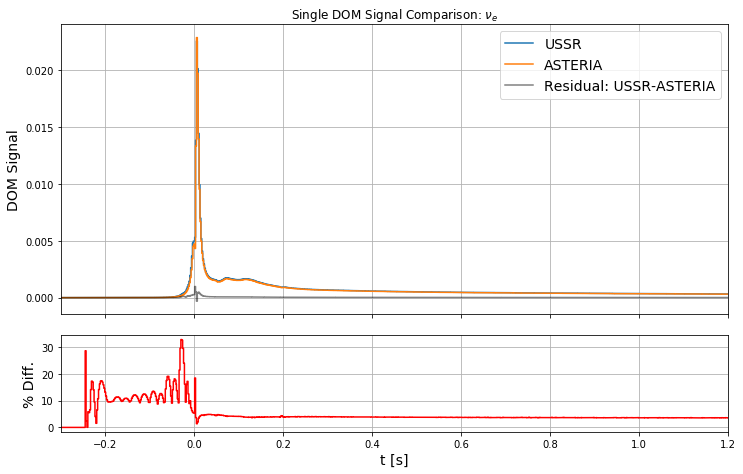

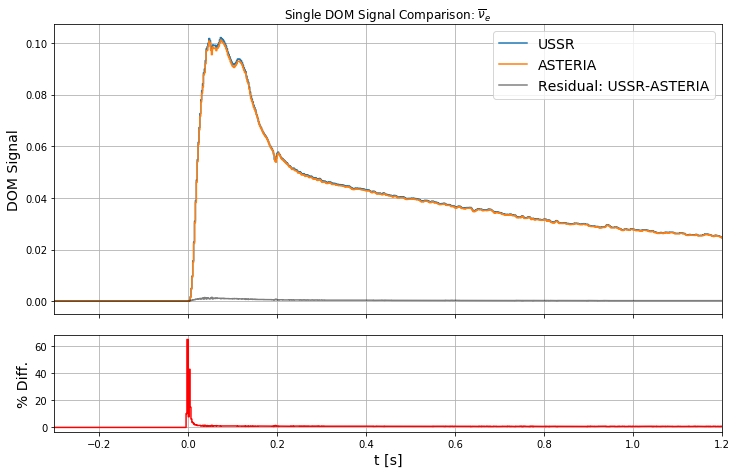

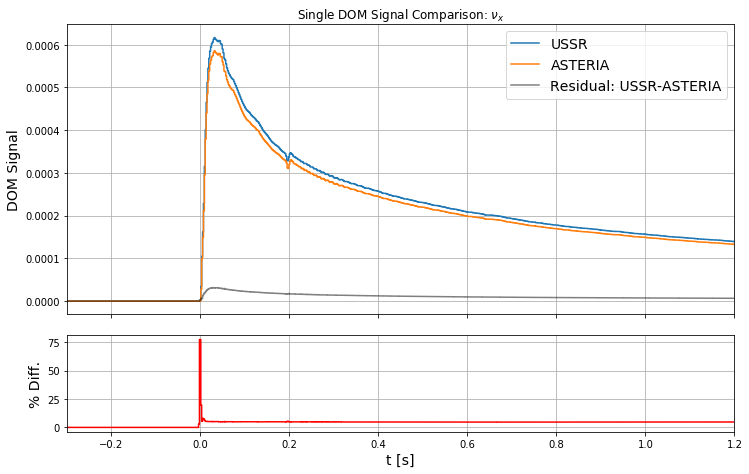

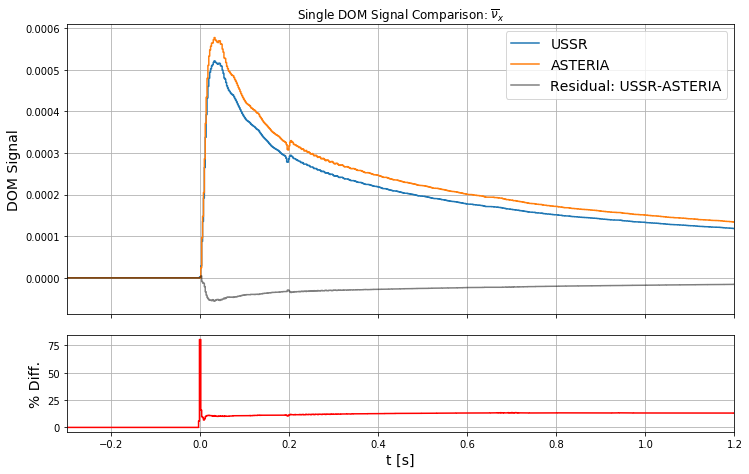

In [7]:
ussrTime, ussrSignal = getUSSRSignal()

for nu, flavor in enumerate(Flavor):
    astrTime, astrSignal = rebin(time, signal_per_DOM[nu], dt, icecube_dt)
    drawComparison((ussrTime, ussrSignal[nu]), (astrTime, astrSignal), flavor)
